In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow import keras


In [2]:
# Load the dataset
data = pd.read_csv("compressed_data.csv.gz", compression='gzip')
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
# Splitting data
X = data.drop(columns=['Cover_Type']).values
y = data['Cover_Type'].values


In [5]:
# Change label from [1-7] to [0-6]
y = y - 1
print(np.unique(y))

[0 1 2 3 4 5 6]


In [6]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
# Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Model MLP PyTorch

In [10]:
# Building an MLP PyTorch Model
class PyTorchModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [11]:
# Initialize model
input_size = X.shape[1]
output_size = 7  # Karena kita punya kelas 0-6
model = PyTorchModel(input_size, output_size)


In [12]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.5012
Epoch 2/10, Loss: 0.2456
Epoch 3/10, Loss: 0.5995
Epoch 4/10, Loss: 0.5732
Epoch 5/10, Loss: 0.4944
Epoch 6/10, Loss: 0.3993
Epoch 7/10, Loss: 0.3395
Epoch 8/10, Loss: 0.4703
Epoch 9/10, Loss: 0.4866
Epoch 10/10, Loss: 0.4655


In [15]:
# Evaluasi the model
model.eval()
y_pred = []
y_true = []
y_scores = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(batch_y.numpy())
        y_scores.extend(torch.softmax(outputs, dim=1).numpy())

In [16]:
# PyTorch evaluation metric
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

print(f"PyTorch Model - Akurasi: {accuracy:.4f}")
print(f"PyTorch Model - Presisi: {precision:.4f}")
print(f"PyTorch Model - Recall: {recall:.4f}")
print(f"PyTorch Model - F1-score: {f1:.4f}")
print(f"PyTorch Model - AUC-ROC: {auc:.4f}")

PyTorch Model - Akurasi: 0.8672
PyTorch Model - Presisi: 0.8668
PyTorch Model - Recall: 0.8672
PyTorch Model - F1-score: 0.8662
PyTorch Model - AUC-ROC: 0.9854


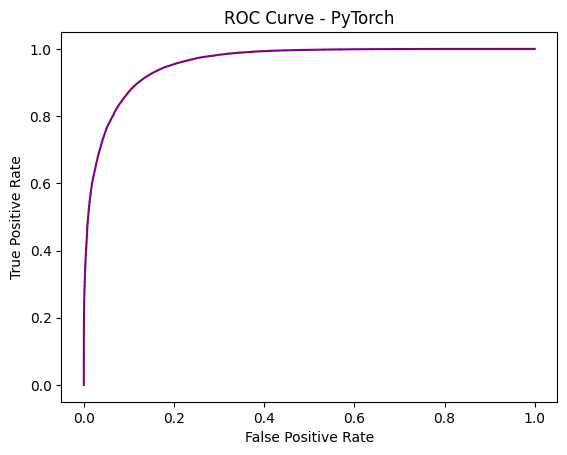

In [19]:
# Plot ROC Curve PyTorch
fpr, tpr, _ = roc_curve(y_true, np.array(y_scores)[:, 1], pos_label=1)
plt.plot(fpr, tpr, color='purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch')
plt.show()

# Model MLP TensorFlow

In [20]:
# Building an MLP TensorFlow model
model_tf = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(input_size,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(output_size, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile TensorFlow model
model_tf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


In [23]:
# Training TensorFlow model
history = model_tf.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7596 - loss: 0.5569 - val_accuracy: 0.8048 - val_loss: 0.4611
Epoch 2/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7832 - loss: 0.5058 - val_accuracy: 0.8222 - val_loss: 0.4263
Epoch 3/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7956 - loss: 0.4785 - val_accuracy: 0.8346 - val_loss: 0.4070
Epoch 4/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - accuracy: 0.8033 - loss: 0.4624 - val_accuracy: 0.8271 - val_loss: 0.4397
Epoch 5/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.8088 - loss: 0.4513 - val_accuracy: 0.8452 - val_loss: 0.3772
Epoch 6/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8124 - loss: 0.4421 - val_accuracy: 0.8514 - val_loss: 0.3742
Epoch 7/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8170 - loss: 0.4337 - val_accuracy: 0.8511 - val_loss: 0.3689
Epoch 8/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8196 - loss: 0

In [24]:
# Evaluate TensorFlow Model
y_pred_tf = model_tf.predict(X_test)
y_pred_labels = np.argmax(y_pred_tf, axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [25]:
accuracy_tf = accuracy_score(y_test, y_pred_labels)
precision_tf = precision_score(y_test, y_pred_labels, average='weighted')
recall_tf = recall_score(y_test, y_pred_labels, average='weighted')
f1_tf = f1_score(y_test, y_pred_labels, average='weighted')
auc_tf = roc_auc_score(y_test, y_pred_tf, multi_class='ovr')

In [26]:
print(f"TensorFlow Model - Akurasi: {accuracy_tf:.4f}")
print(f"TensorFlow Model - Presisi: {precision_tf:.4f}")
print(f"TensorFlow Model - Recall: {recall_tf:.4f}")
print(f"TensorFlow Model - F1-score: {f1_tf:.4f}")
print(f"TensorFlow Model - AUC-ROC: {auc_tf:.4f}")

TensorFlow Model - Akurasi: 0.8632
TensorFlow Model - Presisi: 0.8633
TensorFlow Model - Recall: 0.8632
TensorFlow Model - F1-score: 0.8623
TensorFlow Model - AUC-ROC: 0.9847


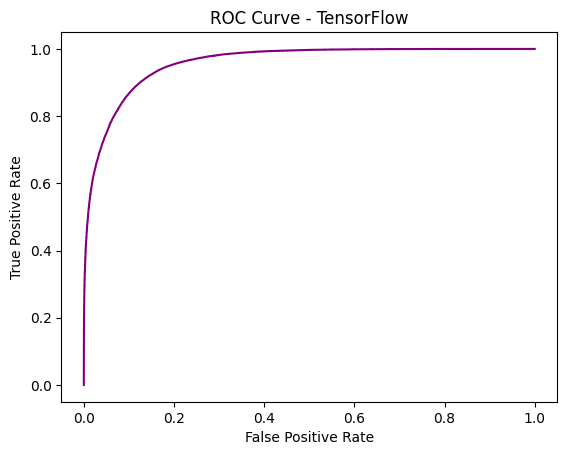

In [27]:
# Plot ROC Curve TensorFlow
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_tf[:, 1], pos_label=1)
plt.plot(fpr_tf, tpr_tf, color='purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow')
plt.show()
